### prepare environment

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [2]:
cd /content/drive/MyDrive/PointingDSP/PointingDSP2021/2021_Analysis

/content/drive/MyDrive/PointingDSP/PointingDSP2021/2021_Analysis


### Valid Participants and Valid Trials

In [3]:
#load shortcutting performance
sc = pd.read_csv('ShortcuttingPerformanceRaw.csv')

In [4]:
#detect problematic subjects (>6 failure trials)
sub_fail = sc.groupby(['subject']).apply(lambda x: (x['strategy']=='Failure').sum()).reset_index(name='total_failure')
sub_fail[sub_fail['total_failure']>6]

,subject,total_failure
32,638,7
33,639,8


In [5]:
#detect problematic trials (>20% unsuccessful participants)
trial_fail = sc.groupby(['TrialID']).apply(lambda x: (x['strategy']=='Failure').sum()).reset_index(name='total_failure')
trial_fail[trial_fail['total_failure']>(len(sub_fail)*0.2)]

,TrialID,total_failure
17,dsp1_22,17


In [6]:
print('Participants with > 6 fialure trials : ')
p_sub=sub_fail[sub_fail['total_failure']>6]['subject'].tolist()
print(p_sub)
print('Trials with > 20% fialure subjects : ')
p_trial = trial_fail[trial_fail['total_failure']>(len(sub_fail)*0.2)]['TrialID'].tolist()
print(p_trial)

Participants with > 6 fialure trials : 
[638, 639]
Trials with > 20% fialure subjects : 
['dsp1_22']


In [7]:
valid_sc = sc.loc[~(sc['TrialID'].isin(p_trial) | sc['subject'].isin(p_sub)),:]
valid_sc.loc[(valid_sc.strategy == 'Failure'),'ES']= np.NaN
valid_sc['ES'] = valid_sc.groupby("subject")['ES'].transform(lambda x: x.fillna(x.mean()))

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### Immersive Pointing Task

#### read data

In [8]:
ipoint_raw = pd.read_csv('immserivePointing.csv').\
            rename(columns = {'Participant No':'Subject','AngluarArror':'AngularError'})
ipoint_raw['Subject']=ipoint_raw['Subject'].astype('int64',copy=False)
ipoint_raw = ipoint_raw[ipoint_raw['Subject'].isin(valid_sc.subject.unique())]
ipoint = ipoint_raw[~ipoint_raw['TrialID'].isin(p_trial)]

In [9]:
round(ipoint.groupby('Subject')['AngularError'].mean().describe(),2)

count    57.00
mean     39.09
std      14.41
min      10.07
25%      27.41
50%      40.30
75%      49.17
max      71.78
Name: AngularError, dtype: float64

In [10]:
from scipy.stats import kurtosis
from scipy.stats import skew

In [11]:
skew(ipoint.groupby('Subject')['AngularError'].mean())

-0.05405233868687772

In [12]:
kurtosis(ipoint.groupby('Subject')['AngularError'].mean())

-0.565785424376509

#### Reliability

In [13]:
%load_ext rpy2.ipython

In [14]:
%%R
install.packages("splithalf")
library("splithalf")

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: also installing the dependencies ‘DEoptimR’, ‘robustbase’, ‘plyr’, ‘patchwork’


R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/DEoptimR_1.0-11.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 36979 bytes (36 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]

In [15]:
%%R -i ipoint
set.seed(123)
splithalf(data=ipoint,
          outcome = "accuracy",
          score = "average",
          halftype = "random",
          permutations = 5000,
          var.ACC = "AngularError",
          var.trialnum = "TrialID",
          var.participant = "Subject",
          average="mean")

  |======================================================================| 100%[1] "condition all complete"
[1] "Calculating split half estimates"
[1] "split half estimates for 5000 random splits"
  condition  n spearmanbrown SB_low SB_high
1       all 57           0.7   0.57     0.8
[1] "this could be reported as: using 5000 random splits, the spearman-brown corrected reliability  estimate for the all condition was 0.7, 95% CI [0.57, 0.8]"


### Subset of Direction Estimation Tasks & Table S1

In [16]:
point_raw = pd.read_csv('PointingData.csv')
point = point_raw[point_raw['Subject'].isin(valid_sc.subject.unique().tolist())]
point = point[point['DSP_Trial'].isin(valid_sc.TrialID.unique())]
point_pre = point[point['Order']=='pre']

In [17]:
round(point_pre.groupby('Subject')['AbsoluError'].mean().describe(),2)

count     57.00
mean      77.71
std       26.41
min       11.49
25%       69.06
50%       84.78
75%       93.79
max      113.89
Name: AbsoluError, dtype: float64

In [18]:
print(stats.ttest_1samp(point_pre.groupby('Subject')['AbsoluError'].mean(), popmean = 90))
def CI_conhen(var,mu):
  print("95% Confidence Interval: {}".format(stats.t.interval(0.95, var.size - 1, var.mean(), stats.sem(var))))
  cohen_d = ( var.mean() - mu )/var.std()
  print("cohen_d {}".format(round(cohen_d,2)))

CI_conhen(point_pre.groupby('Subject')['AbsoluError'].mean(),90)

Ttest_1sampResult(statistic=-3.5116295152046773, pvalue=0.000887975126848254)
95% Confidence Interval: (70.70612068464156, 84.72287285183121)
cohen_d -0.47


In [19]:
point_post = point[point['Order']=='post']
sc_sub = valid_sc.groupby('subject')['ES'].mean().reset_index()
pointpre_sub = point_pre.groupby('Subject')['AbsoluError'].mean().reset_index().\
              rename(columns={'Subject':'subject','AbsoluError':'Point_PreError'})
pointpost_sub = point_post.groupby('Subject')['AbsoluError'].mean().reset_index().rename(columns={'Subject':'subject','AbsoluError':'Point_PostError'})
ipoint_sub = ipoint.groupby('Subject')['AngularError'].mean().reset_index().rename(columns = {'Subject':'subject','AngularError':'iPoint_Error'})
from functools import reduce
sub_performance = reduce(lambda x,y: pd.merge(x,y, on='subject', how='outer'), [sc_sub,pointpre_sub,pointpost_sub,ipoint_sub])
pd.set_option('display.float_format', lambda x: '%.2f' % x)
sub_performance.iloc[:,1:].describe()

,ES,Point_PreError,Point_PostError,iPoint_Error
count,57.00,57.00,57.00,57.00
mean,1.82,77.71,65.30,39.09
std,0.38,26.41,26.97,14.41
min,1.02,11.49,9.30,10.07
25%,1.53,69.06,47.32,27.41
50%,1.82,84.78,67.36,40.30
75%,2.11,93.79,83.95,49.17
max,2.55,113.89,118.65,71.78


In [20]:
from scipy.stats import kurtosis
from scipy.stats import skew
skew(sub_performance.iloc[:,1:])

array([-0.20511285, -0.8617744 , -0.13069815, -0.05405234])

In [21]:
kurtosis(sub_performance.iloc[:,1:])

array([-0.83260369, -0.08695082, -0.7185444 , -0.56578542])

In [22]:
%%R -i point_pre
set.seed(123)
splithalf(data=point_pre,
          outcome = "accuracy",
          score = "average",
          halftype = "random",
          permutations = 5000,
          var.ACC = "AbsoluError",
          var.trialnum = "DSP_Trial",
          var.participant = "Subject",
          average="mean")

  |======================================================================| 100%[1] "condition all complete"
[1] "Calculating split half estimates"
[1] "split half estimates for 5000 random splits"
  condition  n spearmanbrown SB_low SB_high
1       all 57          0.81   0.74    0.87
[1] "this could be reported as: using 5000 random splits, the spearman-brown corrected reliability  estimate for the all condition was 0.81, 95% CI [0.74, 0.87]"


In [23]:
%%R -i point_post
set.seed(123)
splithalf(data=point_post,
          outcome = "accuracy",
          score = "average",
          halftype = "random",
          permutations = 5000,
          var.ACC = "AbsoluError",
          var.trialnum = "DSP_Trial",
          var.participant = "Subject",
          average="mean")

  |======================================================================| 100%[1] "condition all complete"
[1] "Calculating split half estimates"
[1] "split half estimates for 5000 random splits"
  condition  n spearmanbrown SB_low SB_high
1       all 57          0.83   0.76    0.89
[1] "this could be reported as: using 5000 random splits, the spearman-brown corrected reliability  estimate for the all condition was 0.83, 95% CI [0.76, 0.89]"


In [24]:
pip install researchpy

In [25]:
from researchpy import ttest
import researchpy

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [26]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
rpRes = ttest(sub_performance['Point_PreError'], sub_performance['Point_PostError'], equal_variances=True, paired=True)
rpRes

(          Variable      N   Mean     SD    SE  95% Conf.  Interval
 0   Point_PreError 57.000 77.714 26.413 3.499     70.706    84.723
 1  Point_PostError 57.000 65.301 26.967 3.572     58.146    72.457
 2             diff 57.000 12.413 20.063 2.657      7.090    17.736,
                               Paired samples t-test  results
 0  Difference (Point_PreError - Point_PostError) =    12.413
 1                             Degrees of freedom =    56.000
 2                                              t =     4.671
 3                          Two side test p value =     0.000
 4                         Difference < 0 p value =     1.000
 5                         Difference > 0 p value =     0.000
 6                                      Cohen's d =     0.465
 7                                      Hedge's g =     0.462
 8                                  Glass's delta =     0.470
 9                                    Pearson's r =     0.529)

### Figure S1

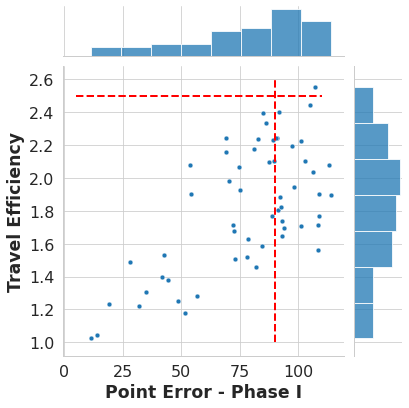

In [27]:
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.8)
g = sns.jointplot(data=sub_performance, x="Point_PreError", y="ES")
g.ax_joint.set_xlabel('Point Error - Phase I', fontweight='bold')
g.ax_joint.set_ylabel('Travel Efficiency', fontweight='bold')
g.ax_joint.plot([90,90], [1,2.6], 'r--', linewidth = 2)
g.ax_joint.plot([5,110], [2.5,2.5], 'r--', linewidth = 2)
plt.show()

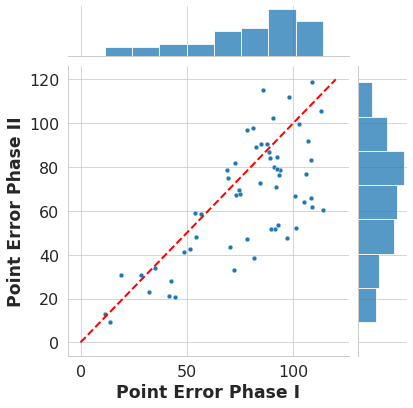

In [28]:
g = sns.jointplot(data=sub_performance, x="Point_PreError", y="Point_PostError")
g.ax_joint.set_xlabel('Point Error Phase I', fontweight='bold')
g.ax_joint.set_ylabel('Point Error Phase II', fontweight='bold')
g.ax_joint.plot([0,120], [0,120], 'r--', linewidth = 2)
plt.show()

### T S2: Observed and Disattenuated Correlation for all

In [29]:
sub_performance[['ES','Point_PreError','Point_PostError','iPoint_Error']].corr()

,ES,Point_PreError,Point_PostError,iPoint_Error
ES,1.000,0.660,0.674,0.716
Point_PreError,0.660,1.000,0.718,0.662
Point_PostError,0.674,0.718,1.000,0.612
iPoint_Error,0.716,0.662,0.612,1.000


In [30]:
#Travel Efficiency - SplitHalf:0.70
print(0.660/math.sqrt(0.81*0.70))
print(0.674/math.sqrt(0.83*0.70))
print(0.716/math.sqrt(0.70*0.70))

#Point-Phase I - SplitHalf:0.81
print(0.718/math.sqrt(0.83*0.81))
print(0.662/math.sqrt(0.70*0.81))

#Point-Phase II - SplitHalf:0.83
print(0.612/math.sqrt(0.70*0.83))

0.8765009801785555
0.88424340696093
1.022857142857143
0.8756748741399741
0.879157043754854
0.8029035089912301


### T S3: Descriptive Stats for Low & High Spatials

In [31]:
print(sub_performance.Point_PreError.median())

84.77894736842104


In [32]:
#### categorize people as low spatial participants v.s. high spatial participants
pt_h = sub_performance[sub_performance.Point_PreError<sub_performance.Point_PreError.median()]
pt_l = sub_performance[sub_performance.Point_PreError>=sub_performance.Point_PreError.median()]
pt_l_sub = pt_l.subject.tolist()
pt_h_sub = pt_h.subject.tolist()
sub_performance['HighSpatial']=sub_performance.Point_PreError<sub_performance.Point_PreError.median()
sub_performance['point_improv']=sub_performance.Point_PreError - sub_performance.Point_PostError

In [33]:
pt_h.iloc[:,1:].describe()

,ES,Point_PreError,Point_PostError,iPoint_Error
count,28.000,28.000,28.000,28.000
mean,1.615,56.994,50.685,30.825
std,0.376,22.194,25.614,13.612
min,1.023,11.495,9.296,10.067
25%,1.301,42.353,30.847,20.028
50%,1.527,62.958,45.502,27.716
75%,1.942,74.637,70.323,41.036
max,2.245,84.263,97.729,62.931


In [34]:
skew(pt_h.iloc[:,1:])

array([ 0.27783814, -0.59604136,  0.25549151,  0.53658868])

In [35]:
kurtosis(pt_h.iloc[:,1:])

array([-1.1308885 , -0.83123196, -1.03065441, -0.44755037])

In [36]:
pt_l.iloc[:,1:].describe()

,ES,Point_PreError,Point_PostError,iPoint_Error
count,29.000,29.000,29.000,29.000
mean,2.019,97.720,79.414,47.075
std,0.273,8.747,20.048,10.116
min,1.560,84.779,47.574,26.745
25%,1.769,90.821,64.070,40.280
50%,2.034,93.789,79.118,47.448
75%,2.233,106.116,90.595,52.786
max,2.551,113.895,118.646,71.776


In [37]:
skew(pt_l.iloc[:,1:])

array([0.18294755, 0.34198736, 0.22598585, 0.40980045])

In [38]:
kurtosis(pt_l.iloc[:,1:])

array([-1.08887572, -1.24435265, -0.81105402,  0.22410127])

#### Reliability for low and high spatials

In [39]:
point_pre_l = point_pre[point_pre.Subject.isin(pt_l_sub)]
point_pre_h = point_pre[point_pre.Subject.isin(pt_h_sub)]
sc_l = valid_sc[valid_sc.subject.isin(pt_l_sub)]
sc_h = valid_sc[valid_sc.subject.isin(pt_h_sub)]
point_post_l = point_post[point_post.Subject.isin(pt_l_sub)]
point_post_h = point_post[point_post.Subject.isin(pt_h_sub)]
ipoint_l = ipoint[ipoint.Subject.isin(pt_l_sub)]
ipoint_h = ipoint[ipoint.Subject.isin(pt_h_sub)]

In [40]:
%%R -i point_pre_l
set.seed(123)
splithalf(data=point_pre_l,
          outcome = "accuracy",
          score = "average",
          halftype = "random",
          permutations = 5000,
          var.ACC = "AbsoluError",
          var.trialnum = "DSP_Trial",
          var.participant = "Subject",
          average="mean")


  |======================================================================| 100%[1] "condition all complete"
[1] "Calculating split half estimates"
[1] "split half estimates for 5000 random splits"
  condition  n spearmanbrown SB_low SB_high
1       all 29         -0.44  -0.67   -0.05
[1] "this could be reported as: using 5000 random splits, the spearman-brown corrected reliability  estimate for the all condition was -0.44, 95% CI [-0.67, -0.05]"


In [41]:
%%R -i point_pre_h
set.seed(123)
splithalf(data=point_pre_h,
          outcome = "accuracy",
          score = "average",
          halftype = "random",
          permutations = 5000,
          var.ACC = "AbsoluError",
          var.trialnum = "DSP_Trial",
          var.participant = "Subject",
          average="mean")

  |======================================================================| 100%[1] "condition all complete"
[1] "Calculating split half estimates"
[1] "split half estimates for 5000 random splits"
  condition  n spearmanbrown SB_low SB_high
1       all 28          0.76   0.61    0.87
[1] "this could be reported as: using 5000 random splits, the spearman-brown corrected reliability  estimate for the all condition was 0.76, 95% CI [0.61, 0.87]"


In [42]:
%%R -i sc_l
set.seed(123)
splithalf(data=sc_l,
          outcome = "accuracy",
          score = "average",
          halftype = "random",
          permutations = 5000,
          var.ACC = "ES",
          var.trialnum = "TrialID",
          var.participant = "subject",
          average="mean")

  |======================================================================| 100%[1] "condition all complete"
[1] "Calculating split half estimates"
[1] "split half estimates for 5000 random splits"
  condition  n spearmanbrown SB_low SB_high
1       all 29          0.23  -0.16    0.56
[1] "this could be reported as: using 5000 random splits, the spearman-brown corrected reliability  estimate for the all condition was 0.23, 95% CI [-0.16, 0.56]"


In [43]:
%%R -i sc_h
set.seed(123)
splithalf(data=sc_h,
          outcome = "accuracy",
          score = "average",
          halftype = "random",
          permutations = 5000,
          var.ACC = "ES",
          var.trialnum = "TrialID",
          var.participant = "subject",
          average="mean")

  |======================================================================| 100%[1] "condition all complete"
[1] "Calculating split half estimates"
[1] "split half estimates for 5000 random splits"
  condition  n spearmanbrown SB_low SB_high
1       all 28           0.8   0.67     0.9
[1] "this could be reported as: using 5000 random splits, the spearman-brown corrected reliability  estimate for the all condition was 0.8, 95% CI [0.67, 0.9]"


In [44]:
%%R -i point_post_l
set.seed(123)
splithalf(data=point_post_l,
          outcome = "accuracy",
          score = "average",
          halftype = "random",
          permutations = 5000,
          var.ACC = "AbsoluError",
          var.trialnum = "DSP_Trial",
          var.participant = "Subject",
          average="mean")

  |======================================================================| 100%[1] "condition all complete"
[1] "Calculating split half estimates"
[1] "split half estimates for 5000 random splits"
  condition  n spearmanbrown SB_low SB_high
1       all 29          0.64   0.44    0.81
[1] "this could be reported as: using 5000 random splits, the spearman-brown corrected reliability  estimate for the all condition was 0.64, 95% CI [0.44, 0.81]"


In [45]:
%%R -i point_post_h
set.seed(123)
splithalf(data=point_post_h,
          outcome = "accuracy",
          score = "average",
          halftype = "random",
          permutations = 5000,
          var.ACC = "AbsoluError",
          var.trialnum = "DSP_Trial",
          var.participant = "Subject",
          average="mean")

  |======================================================================| 100%[1] "condition all complete"
[1] "Calculating split half estimates"
[1] "split half estimates for 5000 random splits"
  condition  n spearmanbrown SB_low SB_high
1       all 28          0.85   0.75    0.92
[1] "this could be reported as: using 5000 random splits, the spearman-brown corrected reliability  estimate for the all condition was 0.85, 95% CI [0.75, 0.92]"


In [46]:
%%R -i ipoint_l
set.seed(123)
splithalf(data=ipoint_l,
          outcome = "accuracy",
          score = "average",
          halftype = "random",
          permutations = 5000,
          var.ACC = "AngularError",
          var.trialnum = "TrialID",
          var.participant = "Subject",
          average="mean")

  |======================================================================| 100%[1] "condition all complete"
[1] "Calculating split half estimates"
[1] "split half estimates for 5000 random splits"
  condition  n spearmanbrown SB_low SB_high
1       all 29          0.24  -0.16    0.58
[1] "this could be reported as: using 5000 random splits, the spearman-brown corrected reliability  estimate for the all condition was 0.24, 95% CI [-0.16, 0.58]"


In [47]:
%%R -i ipoint_h
set.seed(123)
splithalf(data=ipoint_h,
          outcome = "accuracy",
          score = "average",
          halftype = "random",
          permutations = 5000,
          var.ACC = "AngularError",
          var.trialnum = "TrialID",
          var.participant = "Subject",
          average="mean")

  |======================================================================| 100%[1] "condition all complete"
[1] "Calculating split half estimates"
[1] "split half estimates for 5000 random splits"
  condition  n spearmanbrown SB_low SB_high
1       all 28          0.74   0.57    0.86
[1] "this could be reported as: using 5000 random splits, the spearman-brown corrected reliability  estimate for the all condition was 0.74, 95% CI [0.57, 0.86]"


### Low Spatials

In [48]:
### comparing with the chance performance
print(stats.ttest_1samp(pt_l.Point_PreError, popmean = 90))
CI_conhen(pt_l.Point_PreError,90)

Ttest_1sampResult(statistic=4.753156850223426, pvalue=5.4460007136050455e-05)
95% Confidence Interval: (94.39309307712327, 101.04719730400203)
cohen_d 0.88


In [49]:
print(stats.ttest_1samp(pt_l.ES, popmean = 2.51))
CI_conhen(pt_l.ES,2.51)

Ttest_1sampResult(statistic=-9.70831047312435, pvalue=1.8425751529271579e-10)
95% Confidence Interval: (1.915054814708974, 2.1223728785502423)
cohen_d -1.8


In [50]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
rpRes = ttest(pt_l['Point_PreError'], pt_l['Point_PostError'], equal_variances=True, paired=True)
rpRes

(          Variable      N   Mean     SD    SE  95% Conf.  Interval
 0   Point_PreError 29.000 97.720  8.747 1.624     94.393   101.047
 1  Point_PostError 29.000 79.414 20.048 3.723     71.788    87.040
 2             diff 29.000 18.306 22.166 4.116      9.875    26.738,
                               Paired samples t-test  results
 0  Difference (Point_PreError - Point_PostError) =    18.306
 1                             Degrees of freedom =    28.000
 2                                              t =     4.447
 3                          Two side test p value =     0.000
 4                         Difference < 0 p value =     1.000
 5                         Difference > 0 p value =     0.000
 6                                      Cohen's d =     1.272
 7                                      Hedge's g =     1.254
 8                                  Glass's delta =     2.093
 9                                    Pearson's r =     0.643)

In [51]:
print(stats.ttest_1samp(pt_l.Point_PostError, popmean = 90))
CI_conhen(pt_l.Point_PostError,90)

Ttest_1sampResult(statistic=-2.8435600764063502, pvalue=0.008240415236824061)
95% Confidence Interval: (71.78799001382572, 87.03977305248648)
cohen_d -0.53


### T S4: Correlations for Low and High Spatials

In [52]:
pt_l[['ES','Point_PreError','Point_PostError','iPoint_Error']].corr()

,ES,Point_PreError,Point_PostError,iPoint_Error
ES,1.000,-0.196,0.241,0.171
Point_PreError,-0.196,1.000,-0.037,-0.081
Point_PostError,0.241,-0.037,1.000,0.090
iPoint_Error,0.171,-0.081,0.090,1.000


In [53]:
def bi_pr_test(r_c,N):
  df = N-2
  t_value = r_c * np.sqrt(df) / np.sqrt(1-r_c**2)
  p_value = stats.t.sf(abs(t_value), df)*2  # two-sided pvalue = Prob(abs(t)>tt)
  z_u = np.log((1+r_c)/(1-r_c))/2 + 1.96*np.sqrt(1/(N-3))
  z_l = np.log((1+r_c)/(1-r_c))/2 - 1.96*np.sqrt(1/(N-3))
  r_u = (np.exp(2*z_u)-1)/(np.exp(2*z_u)+1)
  r_l = (np.exp(2*z_l)-1)/(np.exp(2*z_l)+1)
  print('t-statistic = %5.3f pvalue = %6.4f df = %2.0f' % (t_value,p_value,df))
  print('95CI = [%4.2f, %4.2f]' % (r_l,r_u))

In [54]:
bi_pr_test(-0.196,29)

t-statistic = -1.039 pvalue = 0.3082 df = 27
95CI = [-0.52, 0.18]


In [55]:
bi_pr_test(0.241,29)

t-statistic = 1.290 pvalue = 0.2079 df = 27
95CI = [-0.14, 0.56]


In [56]:
print(0.241/np.sqrt(0.64*0.23))
print(0.17/np.sqrt(0.24*0.23))
print(0.09/np.sqrt(0.64*0.24))

0.6281496723469377
0.7235680511449364
0.22963966338592295


In [57]:
pt_h[['ES','Point_PreError','Point_PostError','iPoint_Error']].corr()

,ES,Point_PreError,Point_PostError,iPoint_Error
ES,1.000,0.679,0.723,0.831
Point_PreError,0.679,1.000,0.791,0.600
Point_PostError,0.723,0.791,1.000,0.654
iPoint_Error,0.831,0.600,0.654,1.000


In [58]:
#Travel Reliability 0.80
#Point I Reliability 0.79
#Point II Reliability 0.85
#iPoint Reliability 0.74
print(0.68/np.sqrt(0.79*0.80))
print(0.72/np.sqrt(0.85*0.80))
print(0.88/np.sqrt(0.74*0.80))


print(0.791/np.sqrt(0.85*0.79))
print(0.600/np.sqrt(0.74*0.79))

print(0.654/np.sqrt(0.74*0.85))


0.855362829225267
0.8731282501307986
1.14372553880208
0.9652803712319179
0.7847328711713422
0.8246172692222271


### high spatials

In [59]:
print(stats.ttest_1samp(pt_h.Point_PreError, popmean = 90))
CI_conhen(pt_h.Point_PreError,90)

Ttest_1sampResult(statistic=-7.869309456824357, pvalue=1.845099456460329e-08)
95% Confidence Interval: (48.38852605890005, 65.60019574561122)
cohen_d -1.49


In [60]:
# create a list of our conditions
conditions = [sub_performance.subject.isin(pt_h_sub),
              sub_performance.subject.isin(pt_l_sub)]
# create a list of the values we want to assign for each condition
values = ['High','Low']
# create a new column and use np.select to assign values to it using our lists as arguments
sub_performance['Group'] = np.select(conditions, values)

In [61]:
from scipy.stats import ttest_ind
from scipy.stats import t

def welch_ttest_CI(x1, x2,alternative):
    
    n1 = x1.size
    n2 = x2.size
    m1 = np.mean(x1)
    m2 = np.mean(x2)
    
    v1 = np.var(x1, ddof=1)
    v2 = np.var(x2, ddof=1)
    
    pooled_se = np.sqrt(v1 / n1 + v2 / n2)
    delta = m1-m2
    
    tstat = delta /  pooled_se
    df = (v1 / n1 + v2 / n2)**2 / (v1**2 / (n1**2 * (n1 - 1)) + v2**2 / (n2**2 * (n2 - 1)))
    
    # two side t-test
    p = 2 * t.cdf(-abs(tstat), df)
    
    # upper and lower bounds
    lb = delta - t.ppf(0.975,df)*pooled_se 
    ub = delta + t.ppf(0.975,df)*pooled_se
  
    return pd.DataFrame(np.array([delta,lb,ub]).reshape(1,-1),
                         columns=['Difference in mean','lb','ub'])

In [62]:
welch_ttest_CI(pt_h.ES,pt_l.ES,'equal')

,Difference in mean,lb,ub
0,-0.403,-0.579,-0.228


In [63]:
rpRes = ttest(pt_h.ES,pt_l.ES, equal_variances= False)
rpRes

(   Variable      N  Mean    SD    SE  95% Conf.  Interval
 0        ES 28.000 1.615 0.376 0.071      1.469     1.761
 1        ES 29.000 2.019 0.273 0.051      1.915     2.122
 2  combined 57.000 1.821 0.383 0.051      1.719     1.922,
               Welch's t-test  results
 0    Difference (ES - ES) =    -0.403
 1      Degrees of freedom =    50.727
 2                       t =    -4.620
 3   Two side test p value =     0.000
 4  Difference < 0 p value =     0.000
 5  Difference > 0 p value =     1.000
 6               Cohen's d =    -1.231
 7               Hedge's g =    -1.214
 8           Glass's delta =    -1.071
 9             Pearson's r =     0.544)

In [64]:
rpRes = ttest(pt_h['Point_PreError'], pt_h['Point_PostError'], equal_variances=True, paired=True)
rpRes

(          Variable      N   Mean     SD    SE  95% Conf.  Interval
 0   Point_PreError 28.000 56.994 22.194 4.194     48.389    65.600
 1  Point_PostError 28.000 50.685 25.614 4.841     40.753    60.617
 2             diff 28.000  6.309 15.792 2.984      0.186    12.433,
                               Paired samples t-test  results
 0  Difference (Point_PreError - Point_PostError) =     6.309
 1                             Degrees of freedom =    27.000
 2                                              t =     2.114
 3                          Two side test p value =     0.044
 4                         Difference < 0 p value =     0.978
 5                         Difference > 0 p value =     0.022
 6                                      Cohen's d =     0.264
 7                                      Hedge's g =     0.260
 8                                  Glass's delta =     0.284
 9                                    Pearson's r =     0.377)

In [66]:
rpRes = ttest(sub_performance[sub_performance['HighSpatial']].point_improv,sub_performance[~sub_performance['HighSpatial']].point_improv,equal_variances = False,paired=False)
rpRes

(       Variable      N   Mean     SD    SE  95% Conf.  Interval
 0  point_improv 28.000  6.309 15.792 2.984      0.186    12.433
 1  point_improv 29.000 18.306 22.166 4.116      9.875    26.738
 2      combined 57.000 12.413 20.063 2.657      7.090    17.736,
                                 Welch's t-test  results
 0  Difference (point_improv - point_improv) =   -11.997
 1                        Degrees of freedom =    52.308
 2                                         t =    -2.360
 3                     Two side test p value =     0.022
 4                    Difference < 0 p value =     0.011
 5                    Difference > 0 p value =     0.989
 6                                 Cohen's d =    -0.622
 7                                 Hedge's g =    -0.613
 8                             Glass's delta =    -0.760
 9                               Pearson's r =     0.310)

In [67]:
welch_ttest_CI(sub_performance[sub_performance['HighSpatial']].point_improv,sub_performance[~sub_performance['HighSpatial']].point_improv,'equal')

,Difference in mean,lb,ub
0,-11.997,-22.205,-1.788


#### Additional: performance for first half shortcut v.s. second half shortcut

In [67]:
valid_sc['early']=valid_sc['Order']<11

sc_early_late = valid_sc.groupby(['subject','early'])['ES'].mean().to_frame().reset_index()

pip install pingouin
import pingouin as pt

b = sc_early_late.query('early == True')['ES']
a = sc_early_late.query('early == False')['ES']
pt.ttest(a, b, paired=True)

import matplotlib.pyplot as plt
import numpy as np

# your input data:
# befores = np.random.rand(10)
# afters = np.random.rand(10)

#plotting the points
plt.scatter(np.zeros(len(a)), a)
plt.scatter(np.ones(len(b)), b)

# plotting the lines
for i in range(len(a)):
  plt.plot([0,1],[a.iloc[i], b.iloc[i]], c='k',alpha=0.5)

plt.xticks([0,1],['first-half', 'second-half'])

plt.show()